In [13]:
import loconsensus.loconsensus as loconsensus

In [14]:
import pickle
import os
import numpy as np

with open(os.path.join(".", "pickles", "subjects.pkl"), "rb") as f:
    subjects = pickle.load(f)

In [15]:
import multiprocessing
from itertools import combinations_with_replacement

import locomotif.visualize as visualize

import loconsensus.utils as utils
import loconsensus.loconsensus as loconsensus
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

In [19]:
SAMPLING_FREQUENCY = 10



ts_names = [(1, 'walking'), (2, 'walking'), (3, 'walking'), (4, 'walking'), (1, 'cycling'), (4, 'cycling'), (2, 'cycling')]

ts_list = [subjects.get(f'subject10{subject}').get(activity) for (subject, activity) in ts_names]
ts_list = [ts[:60*SAMPLING_FREQUENCY, 6:] for ts in ts_list]


ts_lengths = [len(ts) for ts in ts_list]
n = len(ts_list)
print(f'n: {n}')

   
global_offsets = np.cumsum([0] + ts_lengths)
print(global_offsets)
total_comparisons = n * (n + 1) // 2
print(f'Performing {total_comparisons} total comparisons.')

n: 7
[   0  600 1200 1800 2400 3000 3600 4200]
Performing 28 total comparisons.


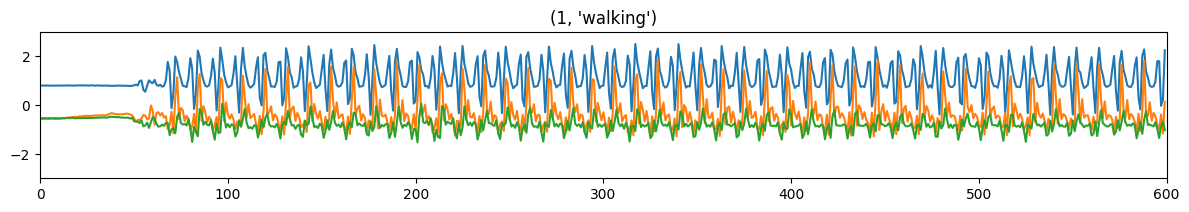

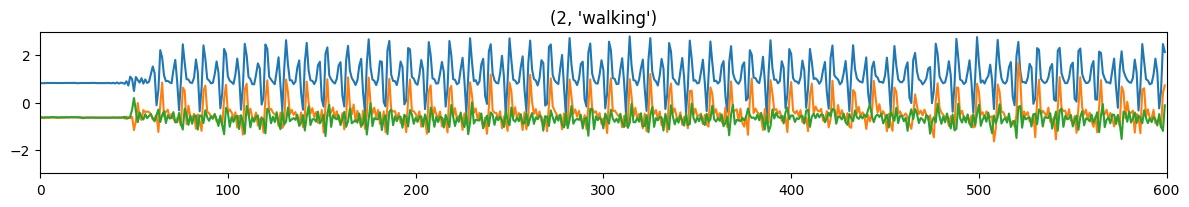

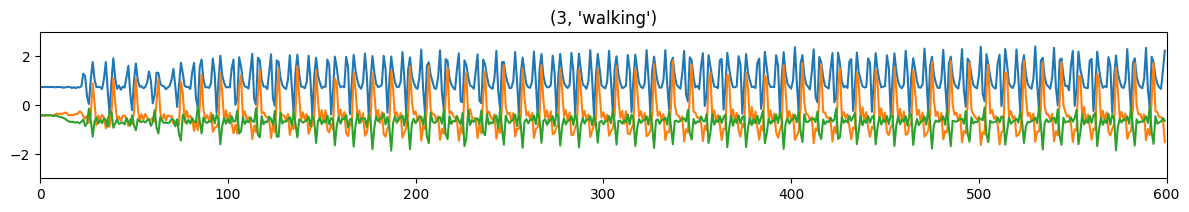

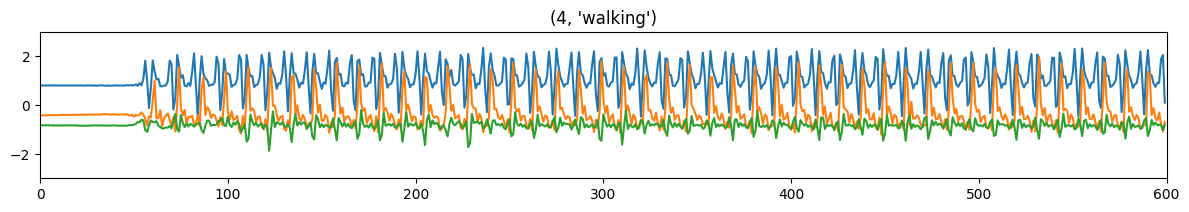

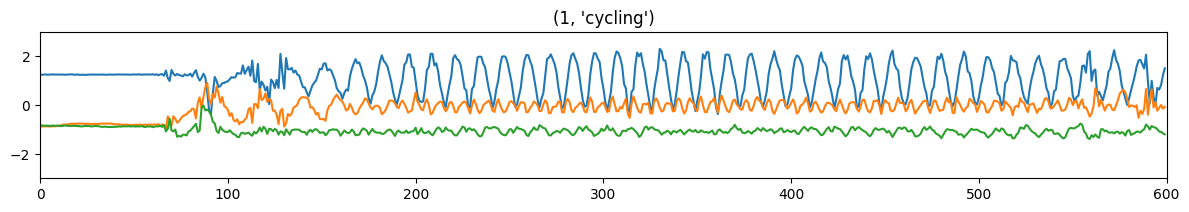

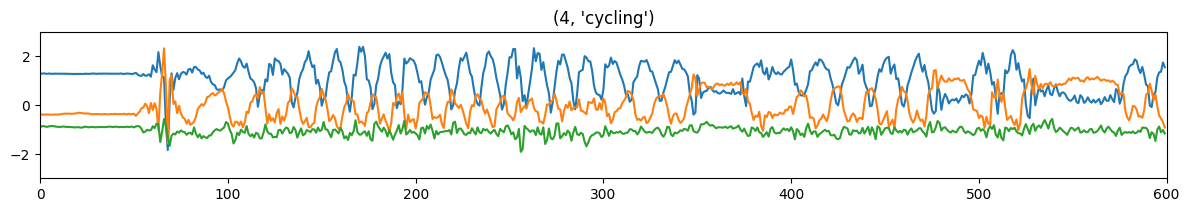

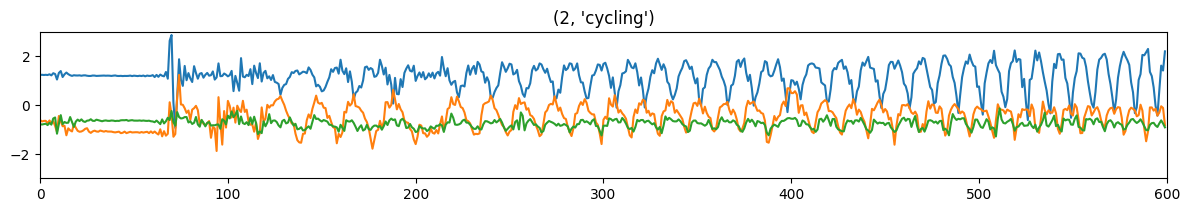

In [20]:
for i, ts in enumerate(ts_list):
    fig, ax = visualize.plot_motif_sets(ts, [], legend=False)
    ax[0].set_ylim([-3, 3])
    ax[0].set_title(ts_names[i])
    plt.show()

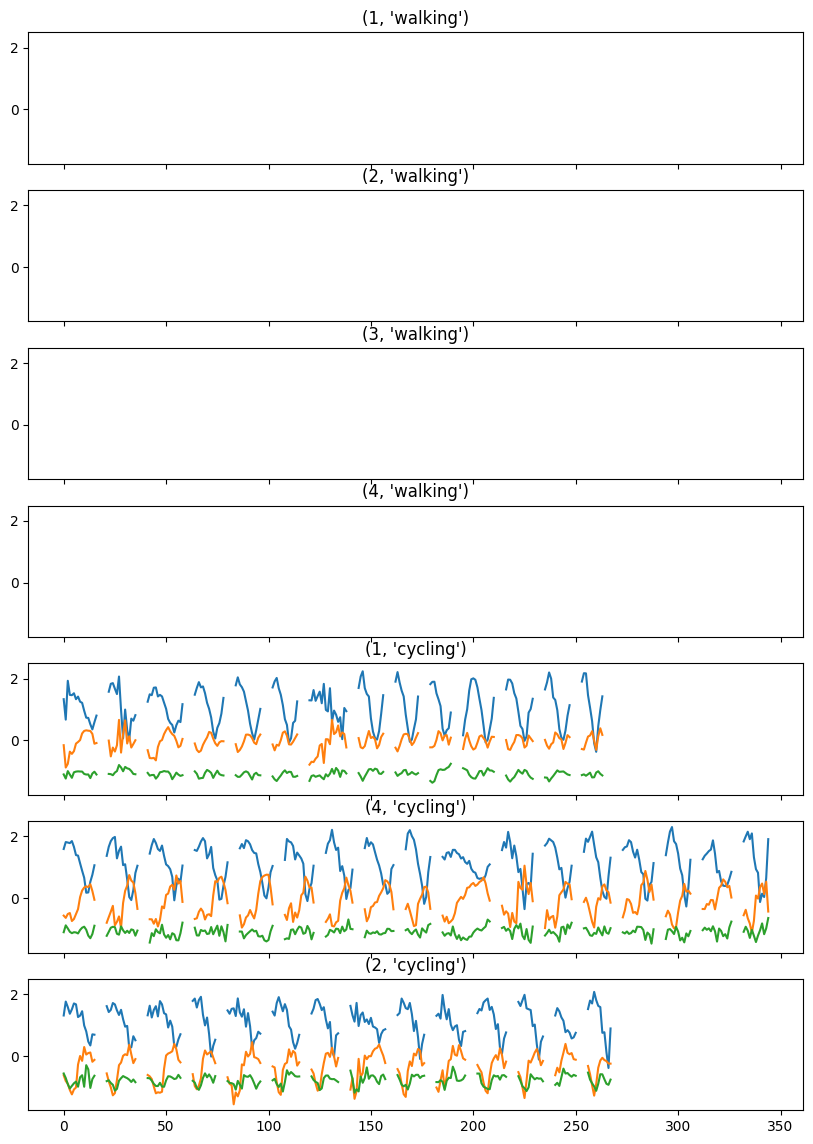

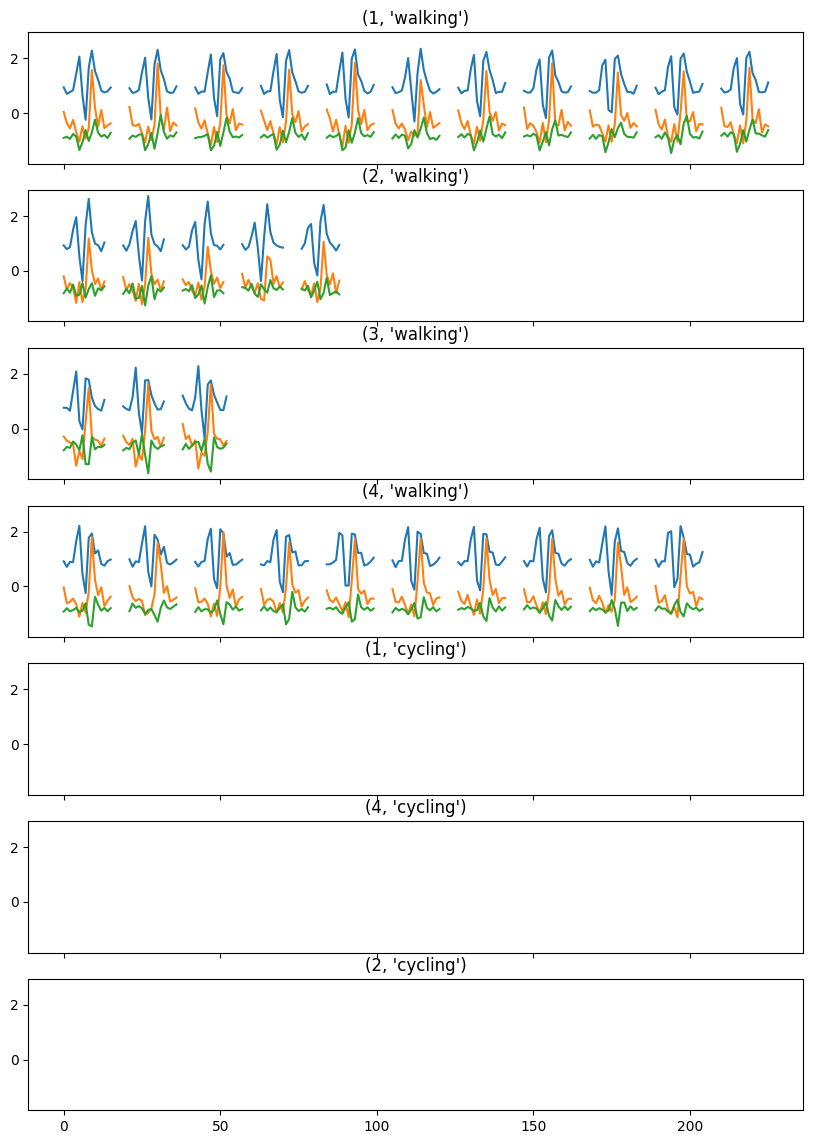

In [21]:
lccs = []
args_list = []
offset_indices = utils.offset_indexer(n)

L_MIN, L_MAX = 15, 50
RHO = 0.8

    # ts1, ts2, global_offsets, offset_indices, l_min, rho, cindex, n


# combinations_with_replacements returns self comparisons, e.g. (ts1, ts1)
for cindex, (ts1, ts2) in enumerate(combinations_with_replacement(ts_list, 2)):
    lcc = loconsensus.get_lococonsensus_instance(
        ts1, ts2, global_offsets, offset_indices[cindex], L_MIN, RHO, cindex, n
    )
    lccs.append(lcc)
    args_list.append(lcc)

num_threads = multiprocessing.cpu_count()

def process_comparison(lcc):
    lcc.apply_loco()

Parallel(n_jobs=num_threads, backend='threading')(
    delayed(process_comparison)(args) for args in args_list
)


for cindex, (_, _) in enumerate(combinations_with_replacement(ts_list, 2)):
    lcc = lccs[cindex]
    r, c = utils.row_col_from_cindex(cindex, n)

    fig, ax, _ = visualize.plot_sm(lcc.ts1, lcc.ts2, lcc.get_sm())

    global_paths = [path.path for path in lcc._paths]
    local_paths  = [np.vstack([path[:, 0] - lcc.rstart, path[:, 1] - lcc.cstart]).T for path in global_paths]

    visualize.plot_local_warping_paths(axs=ax, paths=local_paths)
        
    plt.savefig(f'sm_({r},{c}).png')
    plt.close()

mc = loconsensus.get_motifconsensus_instance(n, global_offsets, L_MIN, L_MAX, lccs)

consensus_motifs = []
for candidate, motif, *_  in mc.apply_motif(nb=2, overlap=0.0):
    consensus_motifs.append(motif)

# map back to local indices in ts 
consensus_motif_sets = []
for motif_set in consensus_motifs:
    motifs = {i: [] for i in range(n)}
    for (s, e) in motif_set:
        i = np.sum(global_offsets <= s) - 1
        motifs[i].append((s - global_offsets[i], e - global_offsets[i]))
    consensus_motif_sets.append(motifs)

for j, consensus_motifs in enumerate(consensus_motif_sets):
    fig, ax = plt.subplots(n, 1, figsize=(10, 2 * len(ts_list)), sharey=True, sharex=True)
    for i, motifs in consensus_motifs.items():
        curr = 0
        for (b, e) in motifs:
            ax[i].set_prop_cycle(None)
            l = e - b
            ax[i].plot(range(curr, curr+l), ts_list[i][b:e])
            curr += l + 5
        ax[i].set_title(ts_names[i])

    plt.savefig(f'motifs_{j}.png')
    
       


